# SE kernel Gaussian processes

In [3]:
import torch
import matplotlib.pyplot as plt

from purias_utils.gaussian_process.prior import ARDGaussianProcessPrior
from purias_utils.gaussian_process.main import GaussianProcessFit

In [15]:
# Input grid, some seen inputs, fewer test inputs
left, right = -3, 3
left_inner, right_inner = left + 0.5, right - 0.5
x_grid = torch.linspace(left, right, 200).unsqueeze(-1)
x_train_indices = sorted(torch.randint(size = [20], low = 0, high = len(x_grid) - 1).numpy().tolist())
x_train = x_grid[x_train_indices, :]
x_test_indices = sorted(torch.randint(size = [5], low = 0, high = len(x_grid) - 1).numpy().tolist())
x_test = x_grid[x_test_indices, :]

In [16]:
# Generate data from medium length cov kernel
with torch.no_grad():
    prior = ARDGaussianProcessPrior(input_dim=1)
    prior.log_dimension_lengths.data = torch.tensor([-0.75])

    y_train_underlying = prior.sample(x_grid)
    y_train = y_train_underlying[x_train_indices] + 0.1 * torch.randn_like(y_train_underlying[x_train_indices])
    y_test = y_train_underlying[x_test_indices]



In [17]:
# Process with length scale too small
with torch.no_grad():
    small_prior = ARDGaussianProcessPrior(input_dim=1)
    small_prior.log_dimension_lengths.data = torch.tensor([-1.8])

    small_process = GaussianProcessFit(prior = small_prior, noise_variance=0.01)
    small_process.fit_posterior(x_train, y_train)
    small_predictions = small_process.predictive_distribution(x_grid)

    m_post_small = small_predictions['m_post']
    K_post_small = small_predictions['K_post']
    std_post_small = K_post_small.diag().sqrt()


In [18]:

# Process with length scale too large
with torch.no_grad():
    large_prior = ARDGaussianProcessPrior(input_dim=1)
    large_prior.log_dimension_lengths.data = torch.tensor([1.0])

    large_process = GaussianProcessFit(prior = large_prior, noise_variance=1.0)
    large_process.fit_posterior(x_train, y_train)
    large_predictions = large_process.predictive_distribution(x_grid)

    m_post_large = large_predictions['m_post']
    K_post_large = large_predictions['K_post']
    std_post_large = K_post_large.diag().sqrt()


In [19]:

# Fit length scale to training data
fit_prior = ARDGaussianProcessPrior(input_dim=1)
fit_process = GaussianProcessFit(prior = fit_prior, noise_variance=1.0)

fit_process.fit_prior(x_train, y_train, num_repeats=1, num_steps=15000)
fit_process.fit_posterior(x_train, y_train)
fit_predictions = fit_process.predictive_distribution(x_grid)

m_post_fit = fit_predictions['m_post'].detach()
K_post_fit = fit_predictions['K_post'].detach()
std_post_fit = K_post_fit.diag().sqrt()

Fitting GP - repeat 1


100%|██████████| 15000/15000 [00:16<00:00, 883.49it/s]

Repeat 0 done. Start NLL = 27.377. End NLL = 12.327.


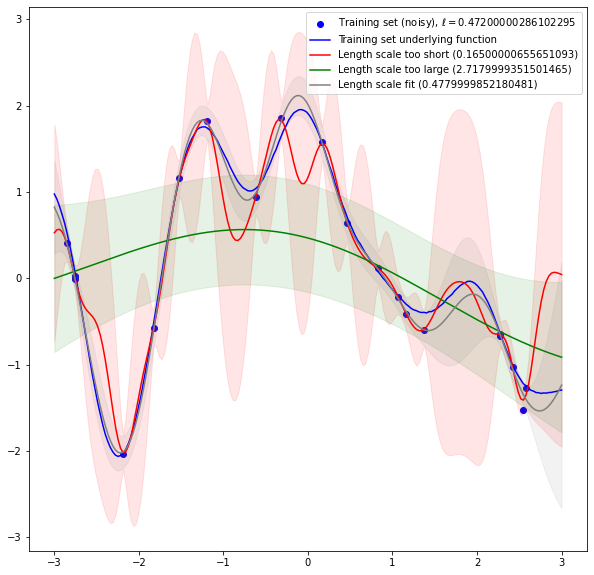

In [21]:
## Plotting

fig, axes = plt.subplots(1, figsize = (10, 10))

axes.scatter(x_train.reshape(-1).numpy(), y_train.reshape(-1).numpy(), color='blue', label = f'Training set (noisy), $\ell=${prior.log_dimension_lengths.exp()[0].round(decimals=3).item()}')
axes.plot(
    x_grid.reshape(-1).numpy(), 
    y_train_underlying.reshape(-1).numpy(), 
    color='blue', 
    label = 'Training set underlying function'
)

axes.plot(
    x_grid.reshape(-1).numpy(), 
    m_post_small.reshape(-1).numpy(), 
    color='red', 
    label = f'Length scale too short ({small_prior.log_dimension_lengths.exp()[0].round(decimals=3).item()})'
)
axes.fill_between(
    x_grid.reshape(-1).numpy(), 
    m_post_small.reshape(-1).numpy() - 2*std_post_small.reshape(-1).numpy(), 
    m_post_small.reshape(-1).numpy() + 2*std_post_small.reshape(-1).numpy(), 
    color='red', alpha = 0.1
)

axes.plot(
    x_grid.reshape(-1).numpy(), 
    m_post_large.reshape(-1).numpy(), 
    color='green', 
    label = f'Length scale too large ({large_prior.log_dimension_lengths.exp()[0].round(decimals=3).item()})'
)
axes.fill_between(
    x_grid.reshape(-1).numpy(), 
    m_post_large.reshape(-1).numpy() - 2*std_post_large.reshape(-1).numpy(), 
    m_post_large.reshape(-1).numpy() + 2*std_post_large.reshape(-1).numpy(), 
    color='green', alpha = 0.1
)

axes.plot(
    x_grid.reshape(-1).numpy(), 
    m_post_fit.reshape(-1).numpy(), 
    color='gray', 
    label = f'Length scale fit ({fit_prior.log_dimension_lengths.exp()[0].round(decimals=3).item()})'
)
axes.fill_between(
    x_grid.reshape(-1).numpy(), 
    m_post_fit.reshape(-1).numpy() - 2*std_post_fit.reshape(-1).numpy(), 
    m_post_fit.reshape(-1).numpy() + 2*std_post_fit.reshape(-1).numpy(), 
    color='gray', alpha = 0.1
)

axes.legend()
plt.show()
